In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD

from functools import partial
import re
import os
import time
import tensorboard

from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling1D, Lambda, UpSampling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input,Flatten,Dense, Dropout, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras import models
from keras.models import Sequential
from keras.optimizers import Adam

In [2]:
def load_files_list(directory):
    '''
    Load the audiofiles inside a directory.
    '''
    return os.listdir(directory)

In [3]:
def normalize(v,m,var):
    return (v + m) / var
    #return (v - np.min(v)) / (np.max(v)-np.min(v))

## Getting the descriptors

In [4]:
DIRECTORY = '/home/belen_alastruey/PYTHON/Autoencoder/'

In [5]:
train_path = DIRECTORY + 'MEL/'

In [6]:
files = load_files_list(train_path)

### Read .npy

In [7]:
descriptors = []
for file in files:
   if "fan" in file:
        descr = np.load(train_path + file)
        descriptors.append(descr)

In [8]:
descriptors[0].shape


(128, 216)

In [9]:
descr = np.asarray(descriptors)

In [10]:
descr.shape

(3060, 128, 216)

In [13]:
normalized_descr=[]
m=np.mean(descr)
var=np.var(descr)
for v in descriptors:
    normalized_descr.append(normalize(v,m, var))

In [14]:
descr = np.asarray(normalized_descr)

### Train - Test split

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test= train_test_split(descr,test_size=0.3, shuffle = True)

In [17]:
X_train.shape

(2142, 128, 216)

In [18]:
X_test.shape

(918, 128, 216)

In [19]:
#Adding channel dimension
X_train = X_train.reshape(X_train.shape[0], 128, 216, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 216, 1)

## Builiding the autoencoder

In [20]:
encoder = Sequential([keras.Input(shape = (128, 216, 1))])

In [21]:
#Layers
encoder.add(Conv2D(32, (3, 3), padding = "same", activation = "relu"))
encoder.add(MaxPool2D(pool_size=(2, 2)))

In [22]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 216, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 108, 32)       0         
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________


In [23]:
decoder = Sequential([keras.Input(shape=(64, 108, 32))])

In [24]:
decoder.add(Conv2D(32, (3, 3), padding = "same", activation = "relu"))
decoder.add(UpSampling2D((2, 2)))
decoder.add(Conv2D(1, (3, 3), padding = "same", activation = "sigmoid"))

In [25]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 108, 32)       9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 128, 216, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 216, 1)       289       
Total params: 9,537
Trainable params: 9,537
Non-trainable params: 0
_________________________________________________________________


In [26]:
autoencoder = Sequential([keras.Input(shape = (128, 216, 1))])

In [27]:
autoencoder.add(encoder)
autoencoder.add(decoder)

In [28]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [29]:
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 108, 32)       320       
_________________________________________________________________
sequential_1 (Sequential)    (None, 128, 216, 1)       9537      
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


## Training

In [30]:
nb_epochs = 50
bs = 30

### Without tensorboard

In [26]:
cb = [EarlyStopping(monitor='accuracy', patience=8, verbose=1, mode='auto')]

In [ ]:
autoencoder.fit(X_train, X_train,
                epochs= nb_epochs,
                batch_size= bs)
#validation_data=(X_test, X_test)

Epoch 1/100
238/238 [==============================] - 2010s 8s/step - loss: 1606.2928 - accuracy: 2.4167e-05
Epoch 2/100
238/238 [==============================] - 2030s 9s/step - loss: 1606.2933 - accuracy: 2.4167e-05
Epoch 3/100
238/238 [==============================] - 2066s 9s/step - loss: 1606.2925 - accuracy: 2.4167e-05
Epoch 4/100
108/238 [============>.................] - ETA: 18:36 - loss: 1607.6257 - accuracy: 2.4470e-05

### With tensorboard

In [31]:
import tensorboard
#import run_logdir from tensorboard

In [32]:
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    run_id = time.strftime("autoencoderMEL_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir() # e.g., './my_logs/run_2019_06_07-15_15_22'

In [33]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [34]:
#Tensorboard, extra parameter: tensorboard --logdir="my_logs/"
autoencoder.fit(X_train, X_train, epochs=nb_epochs, batch_size=bs, validation_data=(X_test, X_test),callbacks=[tensorboard_cb])

Epoch 1/50
 1/72 [..............................] - ETA: 0s - loss: 0.4762 - accuracy: 0.0000e+00WARNING:tensorflow:From /home/belen_alastruey/PYTHON/envs/pythonIntro/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
72/72 [==============================] - 87s 1s/step - loss: 0.1291 - accuracy: 0.0000e+00 - val_loss: 0.0411 - val_accuracy: 0.0000e+00
Epoch 2/50
72/72 [==============================] - 87s 1s/step - loss: 0.0408 - accuracy: 0.0000e+00 - val_loss: 0.0408 - val_accuracy: 0.0000e+00
Epoch 3/50
72/72 [==============================] - 86s 1s/step - loss: 0.0408 - accuracy: 0.0000e+00 - val_loss: 0.0408 - val_accuracy: 0.0000e+00
Epoch 4/50
72/72 [==============================] - 86s 1s/step - loss: 0.0407 - accuracy: 0.0000e+00 - val_loss: 0.0408 - val_accuracy: 0.0000e+00
Epoch 5/5

KeyboardInterrupt: 

## Evaluation 

In [28]:
score = autoencoder.evaluate(X_test, X_test)
print(score)

96/96 [==============================] - 0s 1ms/step - loss: 2.0686 - accuracy: 0.0033
[2.0685837268829346, 0.003269042121246457]


## Saving the model

In [30]:
autoencoder.save('auto_el32_acc86.h5')

# Anomaly detection

## Loading the model

In [16]:
model64 = keras.models.load_model('auto_el64_acc90.h5')
model32 = keras.models.load_model('auto_el32_acc86.h5')
model64.trainable = False
model32.trainable = False

## Loading the dataset with anomalies

In [17]:
DIRECTORY = '/home/belen_alastruey/PYTHON/Autoencoder/'

In [18]:
anomalies_path = DIRECTORY + 'DescriptorsAnomalies/'

In [19]:
files = load_files_list(anomalies_path)

### Read .npy

In [20]:
descriptors_anomalies = []
labels = []
for file in files:
    descr = np.load(anomalies_path + file)
    descriptors_anomalies.append(descr)
    labels.append(re.split(r'_', file)[1])

In [21]:
descr = np.asarray(descriptors_anomalies)
labels = np.asarray(labels)

In [22]:
descr.shape

(5101, 1, 128)

### Train - Test split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(descr,labels,test_size=0.3, stratify = labels)

In [24]:
X_train.shape

(3570, 1, 128)

In [25]:
y_train.shape

(3570,)

In [26]:
X_test.shape

(1531, 1, 128)

In [27]:
reconstructed32 = model32.predict(X_train)

In [28]:
reconstructed64 = model64.predict(X_train)

In [51]:
np.linalg.norm(X_train[0])

29.89349

In [50]:
np.linalg.norm(reconstructed64[0])

2.9372067

In [29]:
errors32 = []
errors64 =[]
for vector, vector32, vector64 in zip(X_train, reconstructed32, reconstructed64) :
    n1 = np.linalg.norm(vector)
    n64 = np.linalg.norm(vector64)
    n32 = np.linalg.norm(vector32)
    print(n1, n32, n64)
    errors32.append(abs(n1-n32))
    errors64.append(abs(n1-n64))

29.89349 2.7356377 2.9372067
15.852339 1.8902233 1.8443393
19.456621 2.1548836 2.3486953
10.010636 1.6532332 1.4637964
17.910397 1.9076232 1.9496002
15.937582 2.1157503 2.0340118
15.852159 1.8478132 1.8987411
13.6697235 1.9313309 1.9014666
19.74608 1.7366817 1.7397126
20.054276 1.8924987 1.7970628
10.561391 1.7347335 1.4669127
23.172665 1.9478813 1.9202828
15.653992 1.8441654 1.7351971
29.771982 1.9652697 1.993117
19.401018 1.7707354 1.8663008
16.968674 2.106501 2.1446571
14.8849535 1.9813472 1.7816031
10.196457 1.6999261 1.3463138
16.04821 1.8609214 1.8947911
14.123772 1.9060078 1.8231266
21.555677 2.3088763 2.5221279
17.229673 1.6794741 1.7760403
13.253766 2.0075262 1.7423384
20.532806 1.7868646 1.8236865
23.596436 1.9691046 1.8885846
23.346458 1.9897854 2.1384103
16.76268 1.9067955 2.0558736
28.052856 2.2557218 2.7327995
13.655764 1.588183 1.731061
19.295721 2.0816638 2.1529355
20.818624 1.9783771 2.0900838
14.147487 1.9637394 1.8601602
15.339939 2.0033817 1.847628
21.915731 2.02019

21.114458 2.0476296 1.7852579
34.429813 2.6042662 2.538066
26.37828 1.8497007 1.8035333
16.892302 1.9684587 2.1369967
16.628445 2.1615002 2.1550188
19.26597 1.824009 1.81389
24.551601 2.143033 2.4051886
14.444168 1.8397678 1.8331293
14.139286 1.9401524 1.9761368
19.222015 2.2114055 2.1234398
12.928168 1.7241122 1.6826056
9.7656765 1.7112504 1.6081837
13.280937 2.0465806 1.8615421
18.140636 1.6939982 1.7555348
15.759438 1.7940078 1.833653
19.684004 1.7734448 1.8693017
21.048332 2.2189684 2.4542658
16.631931 1.9304945 1.8694714
15.49413 1.7690805 1.8920178
21.479006 1.9224219 1.9750065
14.283713 2.0247529 2.0362535
15.220078 2.008374 1.8101127
26.134985 2.1865046 2.4217587
20.937775 2.2925022 2.1524603
19.590183 2.113616 2.2503896
12.344392 1.9788989 1.6167909
14.933163 2.0776553 1.8539152
10.251609 1.6906539 1.3855314
12.377838 1.7625481 1.707027
10.331477 1.8060423 1.4532288
16.522127 1.7979571 1.8648777
19.508862 2.402087 2.4787629
19.40647 2.1136134 2.2991736
16.505545 1.9419092 2.04

14.473806 1.9922842 1.9135298
12.399692 1.8823949 1.6791675
19.510183 2.1308694 2.217195
17.45996 1.9604594 2.0015216
15.792212 1.7493242 1.8293173
16.056297 1.9816536 1.9427729
19.205818 2.0199373 2.1307454
26.984179 2.131355 2.484681
14.80684 1.7927959 1.8762236
25.369858 2.686317 2.7443557
22.54288 2.1071134 2.4954984
21.80751 1.6952714 2.008393
13.755129 1.8557708 1.7569543
30.180138 1.9742683 2.3679945
14.078335 1.9725676 1.9780117
14.616109 1.9900591 1.9243343
13.77019 1.7825917 1.9092511
18.040854 2.305818 2.1824963
19.454573 1.9624065 2.0728977
19.600424 1.9275266 2.0248709
18.89649 1.9655745 2.000134
14.993166 1.9472815 1.956937
23.955414 2.206252 2.3136535
16.936571 1.7940673 1.7779686
9.931291 1.6923839 1.4400954
14.183051 1.8222103 1.9763815
10.023729 1.5864527 1.3974427
20.978386 1.85815 1.9500049
12.882749 1.9335651 1.7254425
22.68246 2.0609944 2.0439146
17.050352 1.9217471 1.9532591
16.28107 1.98588 1.8902636
20.045149 2.0665033 2.096005
26.777325 1.8948492 2.2636926
18.

12.190098 1.9060876 1.7593985
16.017248 1.825242 1.9750133
13.634904 1.6323576 1.73436
16.005472 1.8323082 1.8763971
17.163881 2.1132522 1.9230143
16.844275 1.6933451 1.6347544
29.93927 2.228757 2.233643
18.129154 2.0890622 2.1019902
17.54324 1.9172051 2.1984775
9.758519 1.7355413 1.5960048
14.073927 1.8875402 2.0814006
13.562813 1.8306218 1.7465367
16.069397 1.8642778 1.9284751
19.507872 2.3188531 2.38678
10.736127 1.8851551 1.5618265
15.731402 1.8496577 1.8597744
26.103416 2.574 2.665153
14.929019 1.9746249 1.9875096
21.88915 2.1569376 2.2724726
13.373973 1.8723716 1.6152376
22.08558 2.0248528 2.2712522
31.047995 2.1532068 2.1339672
18.158712 1.7066072 1.9632744
27.882202 2.0097249 2.1115408
22.722343 2.0345278 1.8793317
16.70696 1.9133497 2.0338447
21.277029 2.0195014 2.2075822
24.58279 2.8048022 2.85443
13.059545 1.8155097 1.815221
15.270727 2.027997 1.8918345
18.846025 2.3091934 2.3658366
26.091038 2.7260287 2.83644
11.093575 1.7360957 1.6944398
32.64171 2.1631618 2.352238
14.8218

27.099752 2.504556 2.5958664
13.799375 1.8698428 1.6995867
15.70116 1.8979148 2.0343654
17.897835 1.8346685 2.1854968
22.655497 1.9194427 2.5322227
20.937029 2.1703494 2.191919
31.686981 2.0069532 2.239828
23.94568 1.8036323 1.8370899
26.130125 2.2411988 2.2408779
13.608967 2.0393107 1.810926
21.253069 2.1783452 2.435862
26.04139 1.9822191 2.3198647
10.630739 1.7762129 1.6823119
23.867723 1.7635742 2.2690673
15.371124 1.9662014 1.8654413
19.714233 2.1104712 2.1126184
13.464389 2.097582 1.9192934
15.467754 1.7820907 1.7373239
19.551153 1.6962273 1.633754
17.01789 2.2372055 2.0745463
12.40126 1.7208608 1.6950831
20.167252 1.8092533 1.7792304
23.057373 1.9080471 2.1496115
18.41956 1.8882103 1.7588127
27.272629 1.6923604 2.2507477
16.082092 1.9090433 1.9205388
15.767066 1.790353 1.7614058
12.4193735 1.9708426 1.7856402
24.299852 2.1616566 2.1982143
11.790453 1.7628212 1.6015977
25.018131 1.6771423 2.0992272
13.508976 1.7668526 1.724131
23.040268 2.2105436 2.4602966
12.668638 1.7751201 1.69

15.906086 1.9795369 1.9773597
19.029766 1.763902 1.8441858
12.837759 1.7973936 1.8120472
23.078003 2.0025632 2.095984
19.788954 1.7323779 1.7082765
24.856018 1.792204 1.8140043
16.942545 2.0335872 2.1825805
18.750605 2.0090625 2.046383
18.399565 1.9376317 1.8640484
18.610102 2.0402427 2.1746776
17.261637 1.7795265 1.7051604
12.515447 1.8583518 1.7680902
21.865322 1.7417085 1.8871444
23.446465 2.001907 1.9257425
13.204375 1.8247288 1.7476728
12.095121 1.9750087 1.6454619
15.957143 1.9304339 1.7679008
16.872883 1.8952768 1.9297912
15.746246 1.9317989 1.9825929
19.67504 1.5308901 1.9266582
19.098063 1.7490964 1.8774799
14.244821 2.0286627 2.0090652
28.243166 1.9116155 2.1701205
17.35577 1.9901775 1.9956558
14.025876 2.0815322 2.001368
18.668558 2.1276648 2.1709049
16.46205 1.9327726 1.8339667
24.045622 2.6842077 2.8225424
9.803126 1.653117 1.3935997
19.94203 1.7451471 1.8839705
15.042833 2.1492774 2.0659363
19.72318 2.1052759 2.2488427
18.726358 2.0663745 2.176639
16.07461 1.8434364 1.905

In [52]:
errors32 = []
errors64 =[]
for vector, vector32, vector64 in zip(X_train, reconstructed32, reconstructed64) :
    e32 = np.linalg.norm(vector-vector32) #distancia entre els dos punts 
    e64 = np.linalg.norm(vector-vector64)
    errors32.append(e32)
    errors64.append(e64)

In [53]:
errors32 = np.asarray(errors32)
errors64 = np.asarray(errors64)

### Plots


In [54]:
from matplotlib import pyplot as plt

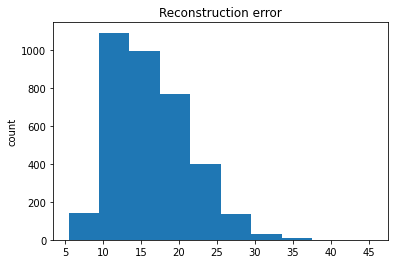

In [55]:
plt.hist(errors64)
plt.title('Reconstruction error')
plt.ylabel('count')

plt.show()

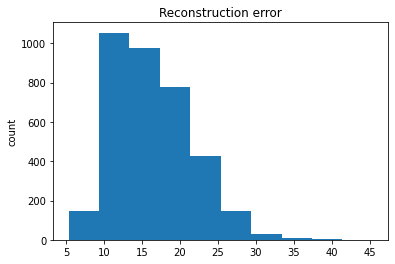

In [56]:
plt.hist(errors32)
plt.title('Reconstruction error')
plt.ylabel('count')

plt.show()

(array([4076.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1025.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

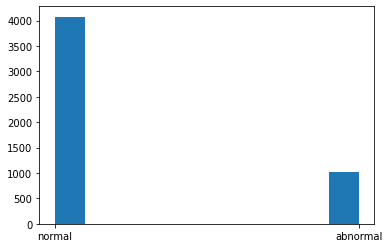

In [57]:
plt.hist(labels)

In [58]:
errors64_normal = []
errors64_abnormal = []
for e, label in zip(errors64, y_train):
    if label == 'normal':
        errors64_normal.append(e)
    else:
        errors64_abnormal.append(e)

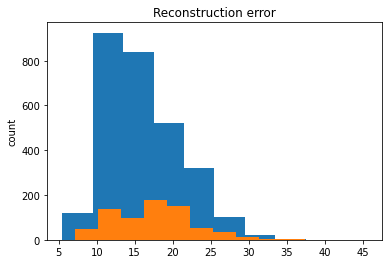

In [59]:
plt.hist(errors64_normal)
plt.hist(errors64_abnormal)
plt.title('Reconstruction error')
plt.ylabel('count')

plt.show()

In [60]:
errors32_normal = []
errors32_abnormal = []
for e, label in zip(errors32, y_train):
    if label == 'normal':
        errors32_normal.append(e)
    else:
        errors32_abnormal.append(e)

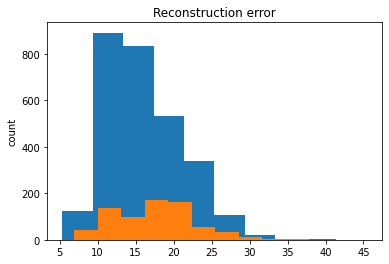

In [61]:
plt.hist(errors32_normal)
plt.hist(errors32_abnormal)
plt.title('Reconstruction error')
plt.ylabel('count')

plt.show()

In [63]:
np.linalg.norm?
